In [8]:
from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib.pyplot as plt


def universal_func(So=2000, Fo=0, mm_dry = 0.028, assumption = 'WTG'):
    g = 13.7 #m/s^2 #gravity
    Pc = 6e4
    Po = 1.01e5
    R_star = 8.3145
    def equations(p): 
        T1, T2, T3, T4, Fa, Fc = p 

        ### Constants
        es0 = 611.2
        M = 0.018
        To = 273.15
        mass_ratio = M/mm_dry

        sigma = 5.67e-8 #W /m^2 K^4  Stefan Boltzmann Constant
        
        H = ((R_star/mm_dry)*T2)/g #scale height
        
        Tc = 230 #Cloud emission temp
        Z_a = np.log(Po/Pc)*H #convection height
        Cp = 1005.7 #J/kgK #heat capacity
        L = 2.501e6 # J/kg #latent heat of vaporization

        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1))
        w_1 = mass_ratio*es_1/(Po - es_1) #saturated mixing ratio
        q1_s = w_1/(1+w_1)

        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        w_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        q2_s = w_2/(1+w_2)

        RH_1 = 0.9 #Relative Humidity
        RH_2 = 0.8 
        RH_3 = 0.3
        q1 = RH_1 * q1_s
        q2 = RH_2 * q2_s #specific humidity
        q3 = RH_3 * q2_s #specific humidity

        #So = 2000 # W/m^2 Solar insolation
        #Fo' = 0 # Ocean heat transport

        #fc = 1.0 # cloud fraction
        
        k1 = 0.2 # Fraction of heat transport to the nightside deposited in the boundary layer
        k2 = 1000 # Relates water vapor to the infrared opacity 
        k3 = 0.08 # relates the strength of convection to the cloud fraction
        Fd = k1*Fa

        fc = k3*np.log(Fc+1.0)
        alpha_p = 0.09+fc - 0.09*fc # planetary albedo

        epsilon_2 = 1 - np.exp(-k2*q2) #emissivity
        epsilon_3 = 1 - np.exp(-k2*q3)

        Eq2 = (1/2)*So*(1-alpha_p)-Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

        Eq3 = Fc - Fa + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

        Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

        Eq5 = Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        Eq6_WTG = T2 - T3

        Eq6_WBG = T2*(1+q2/mass_ratio)/(1+q2) - T3*(1+q3/mass_ratio)/(1+q3)

        Eq7 = Cp*T1 + L*q1_s - (Cp*T2+L*q2_s + g*Z_a)
        
        if assumption == 'WTG': 
            Eq6 = Eq6_WTG
        elif assumption == 'WBG':
            Eq6  = Eq6_WBG
        if index==0:
            return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        if index==1:
            return(q1,q2,q3,alpha_p,epsilon_2,epsilon_3)
        """
        # Old version, to be deleted
        def Eq2(So,alpha_p,Fc,Fo,epsilon_2,sigma,fc,Tc):     
            return (1/2)*So*(1-alpha_p)-Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

        def Eq3(Fc,Fa,epsilon_2,sigma,T1,T2,Tc):
            return Fc - Fa + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

        def Eq4(Fa,Fd,T3,sigma,T4): 
            return Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

        def Eq5(Fo,Fd,epsilon_3,sigma, T3, T4):  
            return Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4

        def Eq6(T2,T3): 
            return T2 - T3

        def Eq7(T1, T2):
            return Cp*T1 + L*q1_s - (Cp*T2+L*q2_s + g*Z_a)

        return (Eq2(So,alpha_p,Fc,Fo,epsilon_2,sigma,fc,Tc), Eq3(Fc,Fa,epsilon_2,sigma,T1,T2,Tc), 
                Eq4(Fa,Fd,T3,sigma,T4), Eq5(Fo,Fd,epsilon_3,sigma, T3, T4),
                Eq6(T2,T3), Eq7(T1,T2))
        """
    index=0
    T1, T2, T3, T4, Fa, Fc = fsolve(equations, (250,250,200,200,200,20))        
    fc_2 = 0.08*np.log(Fc+1)
    if fc_2 >=1:
        print('cloud fraction: ',fc_2)
    index=1
    q1,q2,q3,alpha_p,epsilon_2,epsilon_3 = equations((T1, T2, T3, T4, Fa, Fc))   
    return (T1, T2, T3, T4, Fa, Fc, fc_2,
            q1,q2,q3,alpha_p,epsilon_2,epsilon_3)

In [9]:
Fo = np.linspace(0,50,50)
nele = len(Fo)
T1_arr_WBG, T2_arr_WBG, T3_arr_WBG, T4_arr_WBG, Fa_arr_WBG, Fc_arr_WBG, fc_arr_WBG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

for idx,s in enumerate(Fo):
    T1_arr_WBG[idx], T2_arr_WBG[idx], T3_arr_WBG[idx], T4_arr_WBG[idx], Fa_arr_WBG[idx], Fc_arr_WBG[idx], fc_arr_WBG[idx], \
    q1_arr_WBG[idx],q2_arr_WBG[idx],q3_arr_WBG[idx],alpha_p_arr_WBG[idx],epsilon_2_arr_WBG[idx],epsilon_3_arr_WBG[idx] = universal_func(So = 1200, Fo = s, assumption  = 'WBG')

In [10]:
Fo = np.linspace(0,50,50)
nele = len(Fo)
T1_arr_WTG, T2_arr_WTG, T3_arr_WTG, T4_arr_WTG, Fa_arr_WTG, Fc_arr_WTG, fc_arr_WTG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

for idx,s in enumerate(Fo):
    T1_arr_WTG[idx], T2_arr_WTG[idx], T3_arr_WTG[idx], T4_arr_WTG[idx], Fa_arr_WTG[idx], Fc_arr_WTG[idx], fc_arr_WTG[idx], \
    q1_arr_WTG[idx],q2_arr_WTG[idx],q3_arr_WTG[idx],alpha_p_arr_WTG[idx],epsilon_2_arr_WTG[idx],epsilon_3_arr_WTG[idx] = universal_func(So = 1200, Fo = s, assumption  = 'WTG')

In [239]:
universal_func(So = 4000, assumption = 'WTG')

(326.060615061857,
 313.52592728820986,
 313.52592728820986,
 333.02851851738933,
 497.86922121317286,
 558.7079270905537,
 0.5061932071122593,
 0.09230487639530804,
 0.07057230773818904,
 0.026464615401820886,
 0.5506358184721559,
 1.0,
 0.9999999999967896)

In [240]:
universal_func(So = 4000, assumption = 'WBG')

(322.38582789851495,
 309.5688327168607,
 315.09313737739836,
 334.5984108068292,
 508.9060836841934,
 570.1730902079664,
 0.5078153839148134,
 0.07564397645328154,
 0.05604917805411036,
 0.021018441770291385,
 0.5521119993624801,
 1.0,
 0.9999999992555993)

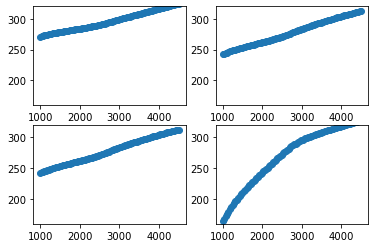

In [241]:
import matplotlib.pyplot as plt
full_arr = [T1_arr, T2_arr, T3_arr, T4_arr]
for idx, arr in enumerate(full_arr):
    plt.subplot(2,2,idx+1)
    plt.scatter(so, arr)
    #plt.xlim(1000,2400)
    plt.ylim(160,320)

In [242]:
import numpy as np

po = 1010
p = 600 
h = 5000

z = np.log(po/p)*h
print(z)

2603.879773095794


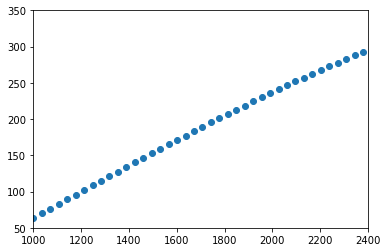

In [243]:
import matplotlib.pyplot as plt
full_arr = [Fa_arr]
for idx, arr in enumerate(full_arr):
    plt.subplot(1,1,idx+1)
    plt.scatter(so, arr)
    plt.xlim(1000,2400)
    plt.ylim(50,350)

(4, 50)


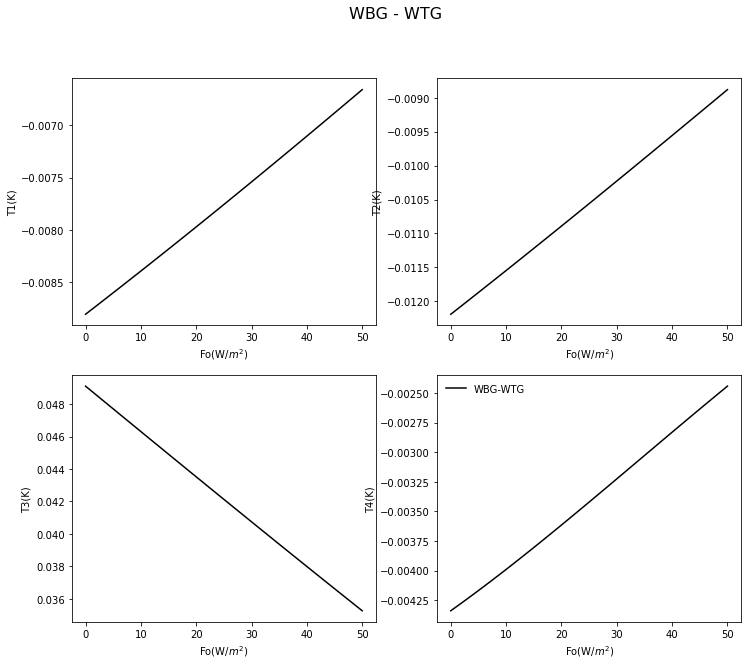

In [14]:
def plot_diff(Fo, xlab = 'Fo', xunit = 'W/$m^2$'): 
    fig = plt.figure(figsize = (12,10))
    plt.suptitle('WBG - WTG', fontsize = 16)
    arr_list_WBG = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
    arr_list_WTG = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
    arr_list = [arr_list_WBG[idx] - arr_list_WTG[idx] for idx in range(4) ]

    nele = len(arr_list)
    name_list = ['T1','T2','T3','T4']
    unit_list = ['K','K','K','K']

    if nele % 2 == 0:
        nrows = (nele)//2
    else:
        nrows = (nele)//2+1
    ncols = 2
    print(np.shape(arr_list))

    for idx, arr in enumerate(arr_list):
        ax  =plt.subplot(nrows, ncols, idx + 1)

        ax.plot(Fo, arr, color = 'k', markersize = 9, label = 'WBG-WTG')
        #ax.set_title(assumption)
        ax.set_xlabel(xlab +'('+ xunit +')')
        ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
        #plt.xlim(1000,2400)
        #plt.ylim(160,320)
        if idx ==3: 
            plt.legend(frameon = False)
    plt.savefig("WTG_WBG_Fodiff.png")
    plt.close()

    return fig
plot_diff(Fo)

(4, 50)
(4, 50)


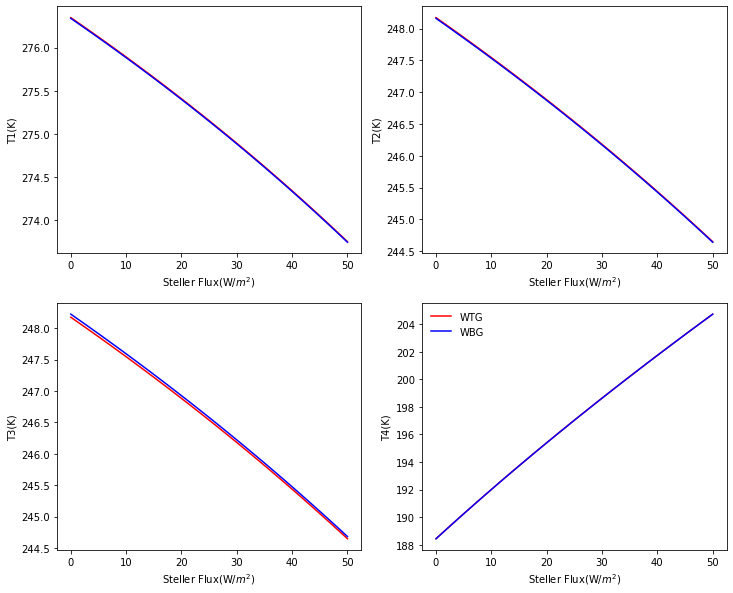

In [16]:
def plot_across_Fo(Fo, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    fig = plt.figure(figsize = (12,10))
    for i_assump, (assumption, my_color) in enumerate(zip(['WTG','WBG'], ['r','b'])):
        if assumption == 'WBG':
            arr_list = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
        elif assumption == 'WTG':
            arr_list = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]

        
        nele = len(arr_list)
        name_list = ['T1','T2','T3','T4']
        unit_list = ['K','K','K','K']

        if nele % 2 == 0:
            nrows = (nele)//2
        else:
            nrows = (nele)//2+1
        ncols = 2
        print(np.shape(arr_list))

        for idx, arr in enumerate(arr_list):
            ax  =plt.subplot(nrows, ncols, idx + 1)

            ax.plot(Fo, arr, color = my_color, markersize = 9, label = assumption)

            #ax.set_title(assumption)
            ax.set_xlabel(xlab +'('+ xunit +')')
            ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
            #plt.xlim(1000,2400)
            #plt.ylim(160,320)
            if idx ==3: 
                plt.legend(frameon = False)
    plt.savefig("WTG_WBG_compare_Fo.png")
    plt.close()

    return fig

plot_across_Fo(Fo)